# Train a deep SNN on the SHD Dataset

In [1]:
import os
import sys

sys.path.append("../../stork-1/")

import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm

# change the default color cycle
np.random.seed(20250129)
plt.rcParams["axes.prop_cycle"] = plt.cycler(
    color=np.random.permutation(cm.batlow(np.linspace(0, 1, 10)))
)

import stork
from stork.activations import CustomSpike
from stork.datasets import HDF5Dataset, DatasetView
from stork.models import RecurrentSpikingModel
from stork.nodes import InputGroup, ReadoutGroup, LIFGroup
from stork.connections import Connection
from stork.generators import StandardGenerator
from stork.initializers import FluctuationDrivenCenteredNormalInitializer
from stork.plotting_new import plot_training

using my stork version - EI-assemblies


## Load Dataset

***To locally run this notebook on your system, download the SHD dataset from: [https://zenkelab.org/datasets/](https://zenkelab.org/datasets/).***
*We need 'shd_train.h5' and 'shd_test.h5'. Move the downloaded files into a folder `data/datasets/hdspikes` in this repo, or change the `datadir` variable below. 

In [2]:
datadir = "/tachyon/groups/gzenke/datasets/hdspikes"

Next, we specify the Dataset Parameters.

In [3]:
nb_inputs = 700
duration = 0.7
time_step = dt = 2e-3
nb_time_steps = int(duration / time_step)
time_scale = 1
unit_scale = 1
validation_split = 0.9

In [4]:
gen_kwargs = dict(
    nb_steps=nb_time_steps,
    time_scale=time_scale / time_step,
    unit_scale=unit_scale,
    nb_units=nb_inputs,
    preload=True,
    precompute_dense=False,
    unit_permutation=None,
)

In [5]:
train_dataset = HDF5Dataset(os.path.join(datadir, "shd_train.h5"), **gen_kwargs)

# Split into train and validation set
mother_dataset = train_dataset
elements = np.arange(len(mother_dataset))
np.random.shuffle(elements)
split = int(validation_split * len(mother_dataset))
valid_dataset = DatasetView(mother_dataset, elements[split:])
train_dataset = DatasetView(mother_dataset, elements[:split])

test_dataset = HDF5Dataset(os.path.join(datadir, "shd_test.h5"), **gen_kwargs)

## Set up the model

In [6]:
# Model Parameters
batch_size = 400
beta = 20
device = torch.device("cuda")
dtype = torch.float


nb_hidden_units = 128
nb_hidden_layers = 3
nb_classes = 20

tau_mem = 20e-3
tau_syn = 10e-3
tau_readout = duration

lr = 5e-3
nb_epochs = 100

In [7]:
act_fn = CustomSpike
act_fn.escape_noise_type = "sigmoid"
act_fn.escape_noise_params = {"beta": beta}

act_fn.surrogate_type = "SuperSpike"
act_fn.surrogate_params = {"beta": beta}


neuron_group = LIFGroup

model = RecurrentSpikingModel(batch_size, nb_time_steps, nb_inputs, device, dtype)

Create regularizers

In [8]:
# Define regularizer parameters (set regularizer strenght to 0, if you don't want to use them)
lowerBoundL2Strength = 100
lowerBoundL2Threshold = 1e-3
upperBoundL2Strength = 0.1
upperBoundL2Threshold = (
    7  # Regularizes spikecount: 7 spikes ~ 10 Hz in 700ms simulation time
)

# Define regularizer list
regs = []

regLB = stork.regularizers.LowerBoundL2(
    lowerBoundL2Strength, threshold=lowerBoundL2Threshold, dims=False
)
regs.append(regLB)
regUB = stork.regularizers.UpperBoundL2(
    upperBoundL2Strength, threshold=upperBoundL2Threshold, dims=1
)
regs.append(regUB)

We initialize the network in the Flucutation-Driven regime, with a target membrane potential standard deviation $\sigma_U=1.0$

In [9]:
sigma_u = 1.0
nu = 15.8

initializer = FluctuationDrivenCenteredNormalInitializer(
    sigma_u=sigma_u, nu=nu, timestep=dt
)

Add input neuron group

In [10]:
input_group = model.add_group(InputGroup(nb_inputs))

Now we want to add multiple hidden layers as well as regularizers for them

In [11]:
upstream_group = input_group
for l in range(nb_hidden_layers):
    hidden_neurons = model.add_group(
        LIFGroup(nb_hidden_units, tau_mem=tau_mem, tau_syn=tau_syn, activation=act_fn)
    )

    hidden_neurons.regularizers.extend(regs)
    con = model.add_connection(Connection(upstream_group, hidden_neurons))
    con.init_parameters(initializer=initializer)

    upstream_group = hidden_neurons

In [12]:
readout_group = model.add_group(
    ReadoutGroup(nb_classes, tau_mem=tau_readout, tau_syn=tau_syn, initial_state=-1e-2)
)

con_ro = model.add_connection(Connection(upstream_group, readout_group))
con_ro.init_parameters(initializer=initializer)

Add monitors for spikes and membrane potential

In [13]:
for i in range(nb_hidden_layers):
    model.add_monitor(stork.monitors.SpikeCountMonitor(model.groups[1 + i]))

for i in range(nb_hidden_layers):
    model.add_monitor(stork.monitors.StateMonitor(model.groups[1 + i], "out"))

Choose loss function (We chose a maximum over time crossentropy loss, where the class is chosen according to the readout neuron that has the highest membrane potential over the simulation time)

In [14]:
loss_stack = stork.loss_stacks.SumOfSoftmaxCrossEntropy()

We select the SMORMS3 optimizer

In [15]:
opt = stork.optimizers.SMORMS3
generator = StandardGenerator(nb_workers=2)

In [16]:
model.configure(
    input=input_group,
    output=readout_group,
    loss_stack=loss_stack,
    generator=generator,
    optimizer=opt,
    optimizer_kwargs=dict(lr=lr),
    time_step=dt,
)

Before we train the model, we monitor the spikes (ca. 20s)

In [17]:
# Monitors spike counts before training
results = {}

res = model.monitor(test_dataset)
for k, v in res.items():
    results["Pre test " + k] = v.cpu().numpy()
    print(k, v.shape)

res = model.monitor(train_dataset)
for k, v in res.items():
    results["Pre train " + k] = v.cpu().numpy()
    print(k, v.shape)
# print(results)

SpikeCountMonitor-LIFGroup torch.Size([6792, 128])
StateMonitor-LIFGroup torch.Size([6792, 349, 128])
SpikeCountMonitor-LIFGroup torch.Size([22020, 128])
StateMonitor-LIFGroup torch.Size([22020, 349, 128])


plotting


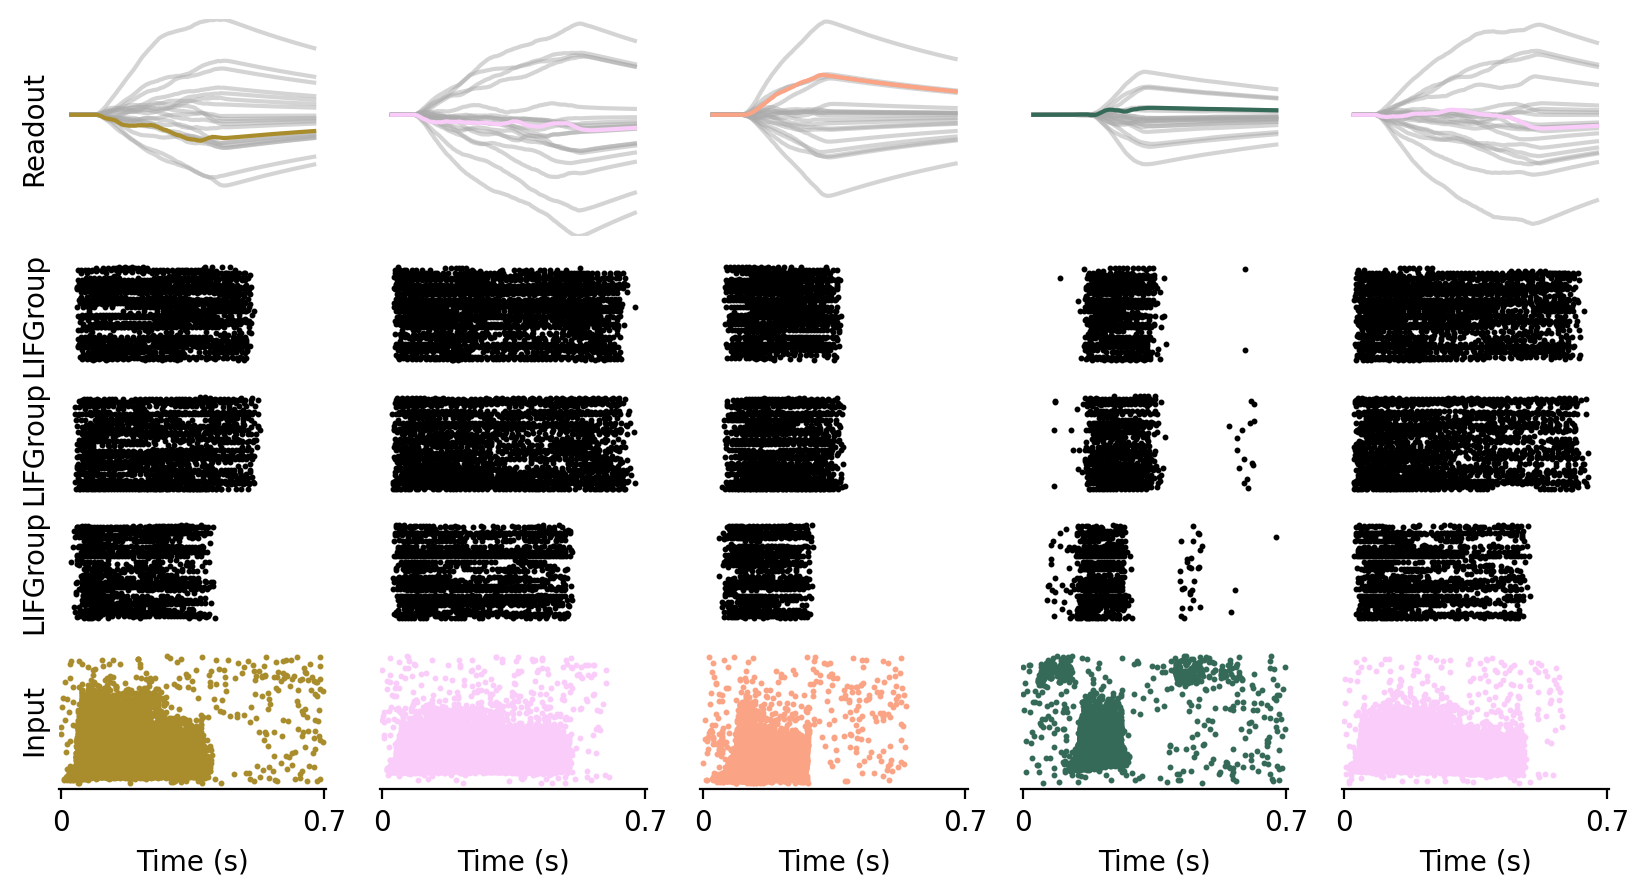

In [18]:
# create nice classification color palette for plotting
colors = cm.batlow(np.linspace(0, 1, nb_classes))

pl = stork.plotting_new.ActivityPlotter(
    model=model,
    data=test_dataset,
    nb_samples=5,
    figsize=(10, 5),
    dpi=200,
    plot_label=True,
    label_color="navy",
    batch_size=batch_size,
    pal=colors,
    scale_input=0.25
)
fig = pl.plot_activity()

## Train

It takes around 50 min using a powerful GPU

In [19]:
history = model.fit_validate(train_dataset, valid_dataset, nb_epochs=nb_epochs, verbose=True)

for k, v in history.items():
    if k in results:
        results[k] = np.concatenate([results[k], v], axis=0)
    else:
        results[k] = np.array(v)

scores = model.evaluate(test_dataset).tolist()
print("Scores", scores)
test_dict = model.get_metrics_dict(scores, prefix="test_")

for k, v in test_dict.items():
    if k in results:
        results[k] = np.concatenate([results[k], [v]], axis=0)
    else:
        results[k] = np.array([v])

00  loss = 1.725e+02, reg_loss = 3.092e+00, acc = 4.9% -- val_loss = 6.975e+01, val_reg_loss = 3.159e-02, val_acc = 4.2% t_iter=17.78
01  loss = 4.076e+01, reg_loss = 1.425e-02, acc = 5.9% -- val_loss = 1.487e+01, val_reg_loss = 2.201e-04, val_acc = 11.0% t_iter=18.44
02  loss = 1.303e+01, reg_loss = 2.408e-04, acc = 7.2% -- val_loss = 1.128e+01, val_reg_loss = 2.070e-04, val_acc = 12.1% t_iter=18.97
03  loss = 9.772e+00, reg_loss = 2.097e-04, acc = 8.6% -- val_loss = 8.416e+00, val_reg_loss = 2.126e-04, val_acc = 12.2% t_iter=18.27
04  loss = 7.200e+00, reg_loss = 2.148e-04, acc = 9.9% -- val_loss = 6.194e+00, val_reg_loss = 2.171e-04, val_acc = 14.7% t_iter=18.44
05  loss = 5.577e+00, reg_loss = 2.176e-04, acc = 10.4% -- val_loss = 5.319e+00, val_reg_loss = 2.183e-04, val_acc = 16.9% t_iter=18.96
06  loss = 4.515e+00, reg_loss = 2.219e-04, acc = 10.4% -- val_loss = 4.169e+00, val_reg_loss = 2.266e-04, val_acc = 11.0% t_iter=19.33
07  loss = 3.628e+00, reg_loss = 2.348e-04, acc = 10.5

plotting


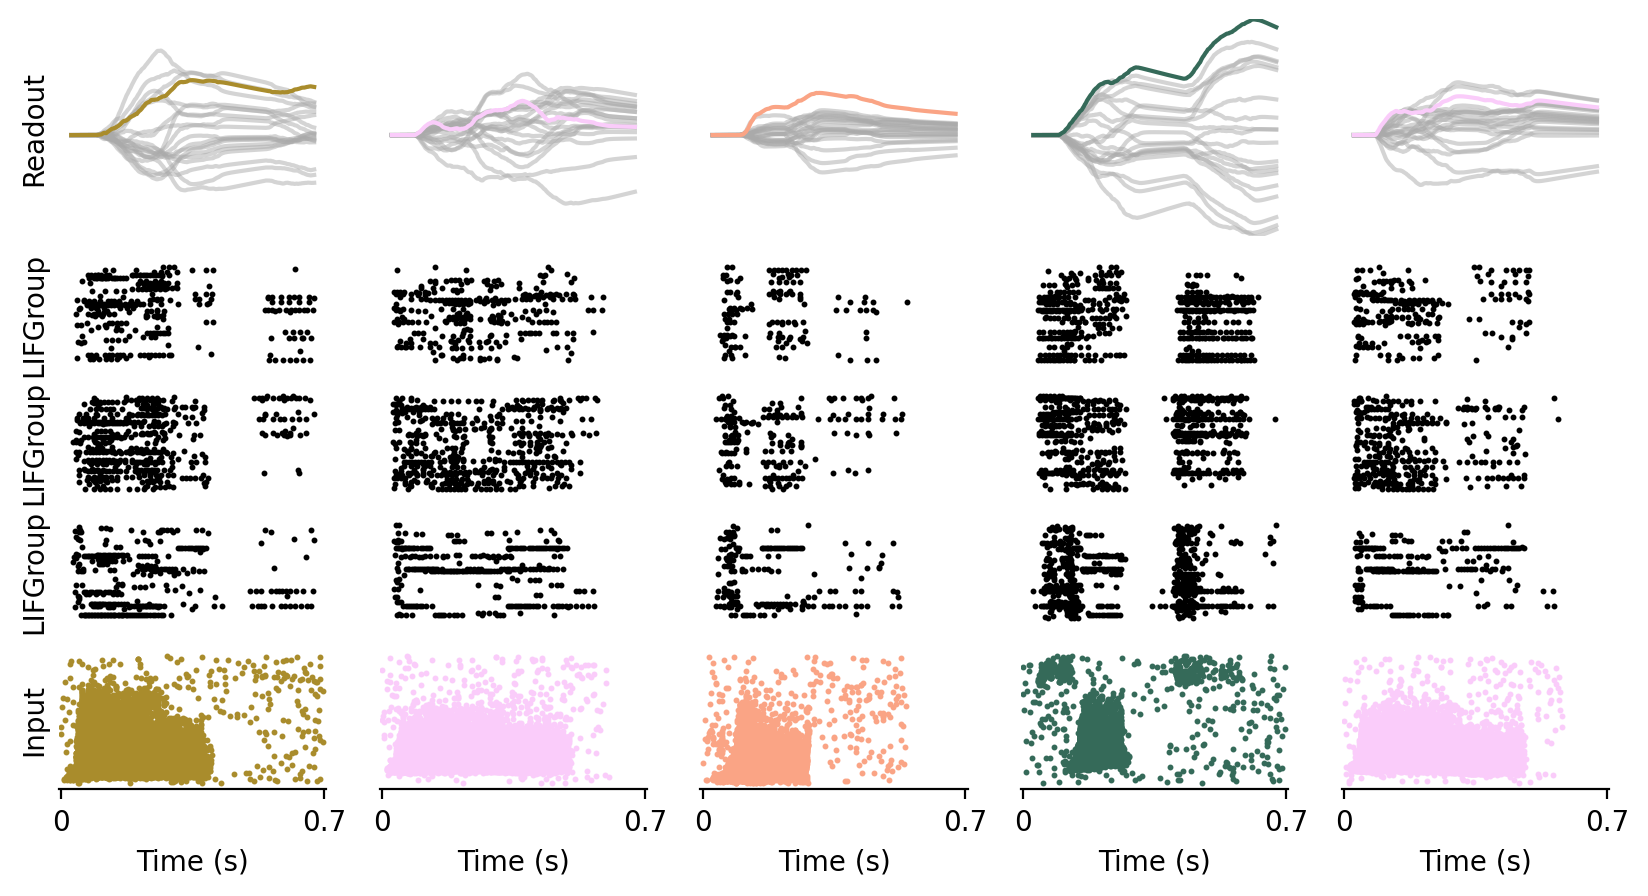

In [20]:
fig = pl.plot_activity()

Monitor the model again after training

In [21]:
res = model.monitor(test_dataset)
for k, v in res.items():
    results["Post test " + k] = v.cpu().numpy()
    print(k, v.shape)

res = model.monitor(train_dataset)
for k, v in res.items():
    results["Post train " + k] = v.cpu().numpy()
    print(k, v.shape)
# print(results)

SpikeCountMonitor-LIFGroup torch.Size([6792, 128])
StateMonitor-LIFGroup torch.Size([6792, 349, 128])
SpikeCountMonitor-LIFGroup torch.Size([22020, 128])
StateMonitor-LIFGroup torch.Size([22020, 349, 128])


## Test

In [22]:
scores = model.evaluate(test_dataset).tolist()

print("Test acc:", np.round(results["test_acc"][-1]*100, 2), "%")

Test acc: 62.94 %


dict_keys(['Pre test SpikeCountMonitor-LIFGroup', 'Pre test StateMonitor-LIFGroup', 'Pre train SpikeCountMonitor-LIFGroup', 'Pre train StateMonitor-LIFGroup', 'loss', 'reg_loss', 'acc', 'val_loss', 'val_reg_loss', 'val_acc', 'test_loss', 'test_reg_loss', 'test_acc', 'Post test SpikeCountMonitor-LIFGroup', 'Post test StateMonitor-LIFGroup', 'Post train SpikeCountMonitor-LIFGroup', 'Post train StateMonitor-LIFGroup'])
['loss', 'reg_loss', 'acc']


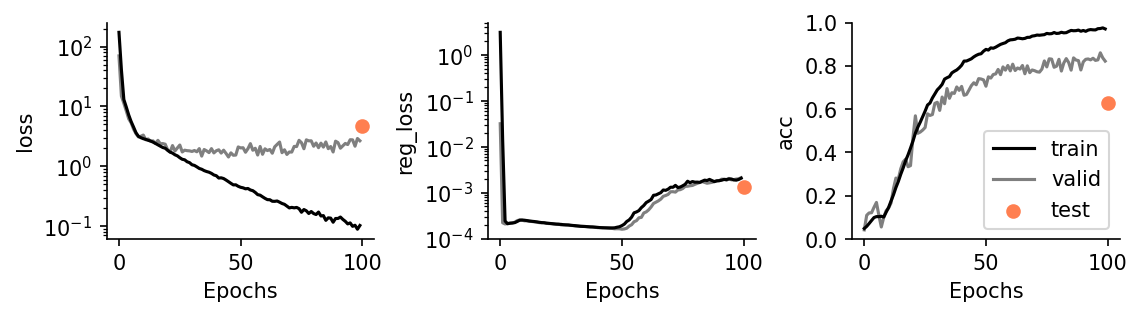

In [23]:
print(results.keys())
names = [k for k in results.keys() if not ("val" in k or "test" in k or "Monitor" in k)]
print(names)

fig = plot_training(
    results,
    nb_epochs=nb_epochs,
    epoch_chunks=1,  # cfg.training.epoch_chunks,
    names=names,
)